# Modelagem de Tópicos - [Gensim](https://pypi.org/project/gensim/)

#### 1 - Importando as bibliotecas

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### 2 - Stopwords


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

#### 3 - Carregar base de dados


In [3]:
# Import Dataset
df = pd.read_json('./Data/newsgroups.json')

print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


#### 4 - Limpeza dos dados



In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


#### 5 -  Tokenização


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


#### 6 - Bigramas e trigramas


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


#### 7 - Remover stopwords, criar bigramas e lematização

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['thing', 'car', 'nntp_poste', 'host', 'rac_wam', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


#### 8 - Dicionário e corpus


In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [9]:
id2word[19]

'look'

#### 9 - Formato legível humano do corpus (frequência-termo)

In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('wonder', 1),
  ('year', 1)]]

#### 10 - Construindo o modelo LDA

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### 11 - Ver tópicos

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.705*"ax" + 0.026*"graphic" + 0.013*"peace" + 0.013*"bomb" + '
  '0.012*"convert" + 0.009*"homosexual" + 0.007*"violence" + 0.006*"capture" + '
  '0.006*"birth" + 0.005*"gif"'),
 (1,
  '0.028*"people" + 0.019*"say" + 0.013*"believe" + 0.013*"reason" + '
  '0.012*"point" + 0.011*"evidence" + 0.011*"mean" + 0.011*"many" + '
  '0.011*"make" + 0.010*"state"'),
 (2,
  '0.057*"trust" + 0.049*"stupid" + 0.043*"session" + 0.032*"registration" + '
  '0.028*"conference" + 0.026*"implementation" + 0.021*"speaker" + '
  '0.021*"beautiful" + 0.018*"fish" + 0.018*"custom"'),
 (3,
  '0.092*"mail" + 0.055*"price" + 0.049*"sale" + 0.040*"cpu" + 0.036*"pin" + '
  '0.033*"disk" + 0.030*"offer" + 0.029*"tape" + 0.022*"board" + 0.021*"bus"'),
 (4,
  '0.208*"window" + 0.068*"server" + 0.062*"package" + 0.044*"motif" + '
  '0.033*"mit" + 0.028*"crash" + 0.022*"application" + 0.014*"event" + '
  '0.013*"programmer" + 0.013*"honor"'),
 (5,
  '0.058*"system" + 0.046*"use" + 0.027*"bit" + 0.025*"compute

#### 12 - Perplexidade e escore de coerência

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.488095424310071

Coherence Score:  0.4915515915416987


#### 13 - Visualização de tópicos


In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/marinaramalhetedesouza/opt/anaconda3/envs/ml-impa/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.326595 -0.134128       1        1  24.194474
1     -0.333206 -0.125166       2        1  21.305275
17    -0.285739 -0.060402       3        1  12.396782
12    -0.134210  0.078355       4        1   6.886257
5     -0.163804  0.054221       5        1   6.569432
11    -0.089425  0.385846       6        1   6.538464
0      0.061982  0.063417       7        1   4.526611
19     0.015051  0.118084       8        1   3.138757
10     0.007019 -0.035341       9        1   2.094718
7      0.057286 -0.007365      10        1   2.041425
3      0.065157 -0.025913      11        1   1.733962
18     0.038375 -0.020861      12        1   1.557110
15     0.067937 -0.000217      13        1   1.385785
13     0.067937 -0.009702      14        1   1.379852
9      0.098338  0.002413      15        1   1.221738
16     0.116859 -0.026336      16        1   1.187277
4      0.161396 -0.048245      17        1   0.728918
8      0.178903 -0.065593      18        1   0.490620
2      0.196708 -0.071182      19        1   0.334778
14     0.200030 -0.071890      20        1   0.287765, topic_info=               Term          Freq         Total Category  logprob  loglift
4435             ax  41584.000000  41584.000000  Default  30.0000  30.0000
18             line  16918.000000  16918.000000  Default  29.0000  29.0000
207           write  13232.000000  13232.000000  Default  28.0000  28.0000
143    organization  10186.000000  10186.000000  Default  27.0000  27.0000
45          article   9135.000000   9135.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
1937            usa     73.728812    267.965757  Topic20  -3.9290   4.5603
5309           vram      0.040029      1.329126  Topic20 -11.4476   2.3481
14611    vram_simms      0.040028      1.329113  Topic20 -11.4476   2.3481
14337      protocol      0.040028      1.329140  Topic20 -11.4476   2.3481
7126        encrypt      0.040028      1.329189  Topic20 -11.4476   2.3480

[846 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3348     19  0.957439      abstract
1391      8  0.998468        accept
3181     13  0.987482  access_digex
1472     16  0.992806       acquire
1554      2  0.998860           act
...     ...       ...           ...
812       9  0.992550     yesterday
628       4  0.372063         young
628       8  0.477807         young
628       9  0.147520         young
2247     14  0.994828          zone

[1117 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 18, 13, 6, 12, 1, 20, 11, 8, 4, 19, 16, 14, 10, 17, 5, 9, 3, 15])

#### 14 - [MAchine Learning for LanguagE Toolkit](https://mimno.github.io/Mallet/)

models.wrappers.ldamallet – Latent Dirichlet Allocation via Mallet
https://radimrehurek.com/gensim_3.8.3/models/wrappers/ldamallet.html

In [19]:
from imp import reload
mallet_path = '/Users/marinaramalhetedesouza/opt/anaconda3/pkgs/mallet-2.0.8-h694c41f_0/bin/mallet' # update this path

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 9458
total tokens: 1098093
<10> LL/token: -10,0683
<20> LL/token: -9,26741
<30> LL/token: -9,02783
<40> LL/token: -8,91606

0	2,5	game team play year player win good season fan hit hockey goal run line score point lose baseball trade period 
1	2,5	article write organization car line make year pay money good cost buy price sell lot big market low deal cheap 
2	2,5	state people government write country israeli article force power attack fact action make land free opinion society support area peace 
3	2,5	gun law government state issue people crime public case weapon firearm bill criminal police kill vote national individual carry person 
4	2,5	key message system information encryption internet post mail bit chip public security part privacy clipper user newsgroup send secure group 
5	2,5	ax max qax ei tm au mp wm_wm rk tq pl_pl air gq rlk part eq fp dm bhj tm_tm 
6	2,5	write line article organization nntp_post

<160> LL/token: -8,68674
<170> LL/token: -8,68624
<180> LL/token: -8,68022
<190> LL/token: -8,67944

0	2,5	game team play year player win good season fan goal hit hockey run score baseball point lose line division period 
1	2,5	year make pay cost money buy write article good lot organization work price line job big sell ve spend large 
2	2,5	people state government country israeli make power opinion support write force fact society article give freedom member peace political land 
3	2,5	gun state law crime weapon case bill firearm police people criminal kill person issue public fire carry vote court federal 
4	2,5	key message system post bit mail encryption information internet chip public security newsgroup part send government privacy group user clipper 
5	2,5	ax max qax tm au ei wm_wm rk tq rlk pl_pl _ gq mp eq fp air tc part tm_tm 
6	2,5	write line article organization nntp_poste host reply university distribution_world post computer_science disclaimer dept originator read distribu

<310> LL/token: -8,6619
<320> LL/token: -8,66292
<330> LL/token: -8,65915
<340> LL/token: -8,65971

0	2,5	game team play year player win good season fan hit hockey run goal lose score baseball point division period pick 
1	2,5	make year pay cost money buy work job good write line lot ve number article big give thing organization price 
2	2,5	people state government israeli country make power opinion fact society support force freedom action peace law question free write member 
3	2,5	gun state law people crime weapon case fire kill firearm police criminal carry person court make public death bill issue 
4	2,5	key system message encryption bit internet chip security public post information mail part privacy phone clipper computer user newsgroup secure 
5	2,5	ax max qax tm ei au wm_wm tq pl_pl rlk gq rk fp air part tm_tm bxn tc ay fq 
6	2,5	line write article organization nntp_poste host reply university distribution_world disclaimer dept opinion hear originator post computer_science rea

<460> LL/token: -8,65213
<470> LL/token: -8,64846
<480> LL/token: -8,64988
<490> LL/token: -8,65234

0	2,5	game team play year player win season good fan hit run hockey goal lose score baseball point pick division period 
1	2,5	year make pay cost money work job line buy good lot organization thing write ve number give spend big deal 
2	2,5	people state government israeli opinion fact make power country article write free give society reason freedom force question peace action 
3	2,5	gun law state crime people fire weapon case kill firearm police person criminal carry court death public legal bill cop 
4	2,5	key system message encryption bit chip internet security information public computer privacy part phone government mail clipper standard user secure 
5	2,5	ax max qax tm au ei wm_wm rlk tq pl_pl rk gq fp air part tm_tm bxn ay wm fq 
6	2,5	line write organization nntp_poste article host reply university distribution_world disclaimer opinion dept originator read usa message computer_s

<610> LL/token: -8,65032
<620> LL/token: -8,6514
<630> LL/token: -8,65026
<640> LL/token: -8,64868

0	2,5	game team play year player win good season fan hit run hockey goal lose score baseball point division period give 
1	2,5	year pay make cost money line write buy organization number good company work lot big thing put spend deal price 
2	2,5	people state government israeli write article opinion power free make society fact support freedom country force law peace case land 
3	2,5	gun law state people crime fire weapon kill firearm case police criminal person court carry death make public rate legal 
4	2,5	key system message encryption bit chip information internet security public computer phone access privacy government network clipper standard part mail 
5	2,5	ax max qax au tm ei wm_wm tq rlk pl_pl gq fp part air tm_tm bxn fq rk eq wm 
6	2,5	line write organization nntp_poste host article reply university distribution_world keyword originator disclaimer dept usa opinion distribution

<760> LL/token: -8,64651
<770> LL/token: -8,64533
<780> LL/token: -8,64707
<790> LL/token: -8,64535

0	2,5	game team play year player win season good fan hit run hockey lose goal score baseball point division period pick 
1	2,5	year make pay cost money lot line organization buy good number write company article big give put price deal work 
2	2,5	people state government write israeli article make opinion country free power society fact freedom law peace case land force give 
3	2,5	gun law people state crime fire case weapon kill firearm police criminal make carry person death court trial public day 
4	2,5	key system encryption bit message chip security information internet technology public government privacy phone computer access network clipper standard part 
5	2,5	ax max qax tm ei au wm_wm rlk tq pl_pl gq air fp tm_tm bxn part fq ei_ei dm bxlt 
6	2,5	line write organization nntp_poste host article reply university distribution_world keyword dept originator usa disclaimer computer_sc

<910> LL/token: -8,6454
<920> LL/token: -8,6448
<930> LL/token: -8,64473
<940> LL/token: -8,64662

0	2,5	game team play year player win season good fan run hockey hit lose goal score baseball point line pick division 
1	2,5	year pay make cost money line buy write good article work lot number organization give put price large big people 
2	2,5	people state government israeli opinion write country article society power make freedom law free case peace fact force reason question 
3	2,5	gun law people state fire crime kill weapon case firearm police criminal carry person make death cop trial court shoot 
4	2,5	key system encryption technology bit message chip information security government public internet access privacy phone computer clipper communication standard secure 
5	2,5	ax max qax tm au ei wm_wm tq pl_pl gq fp part rk air tm_tm bxn fq rlk ei_ei bxlt 
6	2,5	line organization nntp_poste write host article reply university distribution_world keyword dept originator net usa disclaime

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(16,
  [('line', 0.04216922514619883),
   ('organization', 0.02240953947368421),
   ('sale', 0.019668311403508772),
   ('mail', 0.01768092105263158),
   ('interested', 0.012472587719298246),
   ('sell', 0.011764437134502924),
   ('price', 0.010896381578947368),
   ('good', 0.009023209064327485),
   ('computer', 0.008908991228070175),
   ('offer', 0.008337902046783625)]),
 (15,
  [('armenian', 0.014955891803470234),
   ('people', 0.013787462756324122),
   ('war', 0.010399018519600397),
   ('kill', 0.009464275281883507),
   ('history', 0.008821639305953146),
   ('turkish', 0.008782691671048276),
   ('world', 0.008529532044166618),
   ('today', 0.007049521917781543),
   ('attack', 0.006251095402231699),
   ('year', 0.006212147767326829)]),
 (0,
  [('game', 0.030931176851946632),
   ('team', 0.024431023305012456),
   ('play', 0.020762957655167707),
   ('year', 0.0184426928720101),
   ('player', 0.016412461186747194),
   ('win', 0.014041014092196404),
   ('season', 0.010151158426314533),
 

#### 15 - Número ideal de tópicos

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 9458
total tokens: 1098093
<10> LL/token: -9,00367
<20> LL/token: -8,76877
<30> LL/token: -8,65301
<40> LL/token: -8,60921

0	25	ax line write organization article nntp_poste host good year drive problem game reply make time car run ve team university 
1	25	people make system time file find work question give write call program include thing read state information key post window 

<50> LL/token: -8,58934
<60> LL/token: -8,58078
<70> LL/token: -8,57436
<80> LL/token: -8,56907
<90> LL/token: -8,56654

0	25	ax line write organization article nntp_poste host good drive year problem reply game run car time make ve team gun 
1	25	people make system time file question write find give work thing program call include read state information key point government 

<100> LL/token: -8,56531
<110> LL/token: -8,56365
<120> LL/token: -8,56232
<130> LL/token: -8,56003
<140> LL/token: -8,55833

0	25	ax line write organization art

<60> LL/token: -8,69127
<70> LL/token: -8,66533
<80> LL/token: -8,6453
<90> LL/token: -8,63337

0	6,25	year game government key team make play public give player win state encryption good work season security money today time 
1	6,25	people make question thing reason claim true fact point exist word christian good case human evidence answer law argument understand 
2	6,25	ax max _ version_pl sc qax tm sp air line au part rlk ei organization ss keyword mp lk ins_cwru 
3	6,25	line write article organization nntp_poste host reply university post problem distribution_world good keyword find drug opinion ve lot call interested 
4	6,25	file window program run include line set information version mail problem send system code image user email address application list 
5	6,25	system drive bit space card computer work high sale datum chip fast price design line speed scsi model cost monitor 
6	6,25	people gun kill man day make state time give child live write armenian love die woman happen law 

<440> LL/token: -8,5902

0	6,25	year game key make team good play player give time win point government encryption work money season job technology lose 
1	6,25	people make question thing word point true write give life claim reason exist good time man christian read fact book 
2	6,25	ax max line _ organization version_pl qax tm air sc reply part au netcom ss rlk ei line_communication services_gu sp 
3	6,25	line write article organization nntp_poste host reply university post distribution_world problem day find read keyword drug study research food lot 
4	6,25	file window program information include system mail version image run line send code user set message address application email list 
5	6,25	drive system line space card problem work bit computer driver sale high price scsi cost speed disk chip model organization 
6	6,25	people state gun kill government armenian law child country time day happen make attack year live death fire give war 
7	6,25	car good thing time ve back make wo

<810> LL/token: -8,60076
<820> LL/token: -8,60046
<830> LL/token: -8,60005
<840> LL/token: -8,59927

0	6,25	year game good make team line play player point win give time key money run encryption season job work lose 
1	6,25	people make thing question write true word point life reason claim time man give exist christian good fact read book 
2	6,25	ax max _ line organization qax tm sp air au sc reply netcom rlk ei part ss line_communication services_gu lk 
3	6,25	line write article organization nntp_poste host reply university post distribution_world problem find read opinion research drug study question keyword day 
4	6,25	file window program information include key system mail image send version run code line message user set application list source 
5	6,25	system drive line work problem space card computer bit driver sale organization chip high price scsi disk cost monitor speed 
6	6,25	people state government gun kill law armenian country make child attack year public fact force give

<110> LL/token: -8,67456
<120> LL/token: -8,66918
<130> LL/token: -8,665
<140> LL/token: -8,65996

0	3,57143	post book read question group find word point issue follow make church time answer claim thing good discussion give write 
1	3,57143	file program image include display line code information application set version source send info format graphic write type list entry 
2	3,57143	game year team play good player win line season hit point time lose fan run make give hockey goal start 
3	3,57143	people write make true exist reason evidence claim question fact human law religion state thing argument opinion truth matter life 
4	3,57143	thing time turn bike back ve good light put make ride power side ground long leave wire road run bad 
5	3,57143	work make people time year problem give ve talk job day question money school lot kind thing call change program 
6	3,57143	write article line organization nntp_poste host car reply university distribution_world opinion computer_science guess 


0	3,57143	post book read find group time word point thing question church give make day issue idea discussion view good reference 
1	3,57143	file program image window include server application display version code set information source software graphic format line send run user 
2	3,57143	game year team play good player win line season hit point run make fan lose time give goal hockey start 
3	3,57143	people make question true reason exist claim life write religion evidence opinion fact argument thing wrong human truth agree faith 
4	3,57143	car thing bike turn good time back ve make light ride power ground leave big put side wire engine run 
5	3,57143	work make people time problem year ve lot day job thing food good money talk effect kind school study question 
6	3,57143	write line article organization nntp_poste host reply university distribution_world post hear read computer_science guess net opinion news keyword dept usa 
7	3,57143	drive problem system card window run bit work d

<560> LL/token: -8,63076
<570> LL/token: -8,6301
<580> LL/token: -8,63096
<590> LL/token: -8,63096

0	3,57143	book word time christian read give find day make church point write man post people thing follow speak bible group 
1	3,57143	file program window image include version display server application set code source information software graphic format run line send entry 
2	3,57143	game year team play good player win season run make line time hit lose point fan give hockey goal start 
3	3,57143	people question make life true exist thing write reason claim argument evidence religion wrong fact good truth human opinion love 
4	3,57143	car bike turn back time light thing good power ride ground ve make put leave engine wire big side road 
5	3,57143	work make time people ve year lot problem day thing job food study question good kind give find effect talk 
6	3,57143	write line article organization nntp_poste host reply university post distribution_world read hear opinion computer_science

<810> LL/token: -8,63224
<820> LL/token: -8,63176
<830> LL/token: -8,63301
<840> LL/token: -8,63407

0	3,57143	book christian people man word make time love church day give find thing read write speak world great bible good 
1	3,57143	file program window image include version display server set application software code source graphic run format information line send entry 
2	3,57143	game year team play good player win time season make line point hit lose run fan give goal hockey start 
3	3,57143	people question make exist claim write reason thing true point evidence religion argument wrong life fact human statement good opinion 
4	3,57143	car bike thing turn back make good time light ride ve power ground put engine wire side big work drive 
5	3,57143	work make time ve people year problem day study lot food thing job good effect find kind question group talk 
6	3,57143	write line article organization nntp_poste host reply university post distribution_world hear read guess news keyword 

type: 38608 new topic: 18
12:63 
java.lang.ArrayIndexOutOfBoundsException: 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
type: 16071 new topic: 12
0:64 6:63 
java.lang.ArrayIndexOutOfBoundsException: 2
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPo

<50> LL/token: -9,30281
<60> LL/token: -9,24425
<70> LL/token: -9,20965
<80> LL/token: -9,18512
<90> LL/token: -9,1662

0	2,5	key system bit encryption technology government public chip security message information phone privacy clipper part secure standard communication protect provide 
1	2,5	christian claim question true exist religion people word church truth read argument faith evidence belief atheist reason follow bible answer 
2	2,5	space system science cost datum launch research project earth design base satellite technology mission center program moon model year large 
3	2,5	max qax tm au wm_wm tq dm pl_pl fp tm_tm ay sl fq ei ei_ei bxlt mwt giz fax pmfq 
4	2,5	mail post send list information address email internet computer group message include sale network interested user info service offer line 
5	2,5	write world article war state israeli give attack history jewish force land call country claim book fact line number people 
6	2,5	law state government people support make issu

<210> LL/token: -9,10389
<220> LL/token: -9,10023
<230> LL/token: -9,09932
<240> LL/token: -9,09693

0	2,5	key system bit encryption technology chip security government public message information phone privacy standard clipper part secure communication datum provide 
1	2,5	christian claim question exist religion word true church argument truth faith evidence belief atheist bible follow man book god sin 
2	2,5	space system science launch project earth datum research design technology base cost satellite year mission program moon high center large 
3	2,5	max qax tm wm_wm fax tm_tm fq mwt giz pmfq bxlt wmbxn pmf nrizwt biz chz_chz chuck_petch pl_pl gizwt bxom 
4	2,5	mail post send list information address internet email include group computer message network interested offer service sale contact fax info 
5	2,5	war world israeli state history attack turkish jewish give land force people call country claim government article book peace man 
6	2,5	law state government people make issue supp

<360> LL/token: -9,08211
<370> LL/token: -9,08099
<380> LL/token: -9,07882
<390> LL/token: -9,07948

0	2,5	key system bit encryption chip technology government security public message phone privacy information clipper part secure standard datum communication provide 
1	2,5	christian question exist religion true word argument church claim truth faith evidence belief atheist man follow bible book life thing 
2	2,5	space system launch earth project datum science technology research year satellite design cost base mission program moon model orbit center 
3	2,5	qax max wm_wm tm_tm fax tm fq bxlt giz pmfq mwt wmbxn pmf nrizwt biz chz_chz chuck_petch bxom rax pl_fq 
4	2,5	mail post send information list address internet email include group computer message copy interested book network service contact newsgroup info 
5	2,5	people war israeli turkish attack world government land jewish state force give history country peace fact side turk german today 
6	2,5	state law government make people iss

<510> LL/token: -9,06869
<520> LL/token: -9,06942
<530> LL/token: -9,06828
<540> LL/token: -9,06744

0	2,5	key bit encryption system technology chip security public government message phone information privacy part clipper secure standard datum communication provide 
1	2,5	christian question religion word exist true church argument faith truth evidence claim belief atheist man follow book bible find life 
2	2,5	space system launch science earth project datum research cost technology satellite mission year design base high program model moon large 
3	2,5	qax fq mwt pmfq wmbxn biz nrizwt pmf pl_fq bizw mfq m__wt wwiz_bhj vma tct mnuy gizw_ei giz_bhj biz_giz moody 
4	2,5	mail post send information list internet address email include group message computer copy contact interested info newsgroup book faq service 
5	2,5	people armenian war israeli attack world turkish land state government jewish kill force history give country peace today call turk 
6	2,5	law state government people make su

<660> LL/token: -9,06353
<670> LL/token: -9,06096
<680> LL/token: -9,06132
<690> LL/token: -9,05939

0	2,5	key system bit encryption technology chip government security phone public message privacy information clipper standard part secure communication datum call 
1	2,5	christian question religion true word church truth faith exist man life belief people atheist book love bible follow answer god 
2	2,5	space system science launch earth datum year research technology cost project satellite program base mission design moon large high center 
3	2,5	qax fq mwt pmfq biz nrizwt pmf pl_fq klj_m mi wwiz_bhj tct m__wt gizw_ei uz_nrizwt fullpath bu bhjn steven bj_nrhj 
4	2,5	mail send post information list address group internet include email computer message contact copy faq book service newsgroup network user 
5	2,5	people armenian war israeli world attack turkish force government kill jewish give land history country state today peace live center 
6	2,5	state law government make support publi

<810> LL/token: -9,05503
<820> LL/token: -9,05474
<830> LL/token: -9,0524
<840> LL/token: -9,05568

0	2,5	key system bit encryption chip technology security government phone public message information privacy clipper part secure communication datum standard provide 
1	2,5	christian religion word man people church life faith belief follow atheist love truth world book bible true find god sin 
2	2,5	space system launch science earth year datum technology project research satellite cost mission high design base program moon center orbit 
3	2,5	qax mwt pmfq nrizwt fq biz km pmf klj_m glover bu wwiz_bhj tm_tm bj_nrhj farzin_mokhtarian oswego_oswego ile eqtm gizw dennis_kriz 
4	2,5	mail send information post list address include group internet email message copy computer contact faq service book newsgroup user network 
5	2,5	people armenian war israeli attack turkish world force land kill government jewish history state give today country live call leave 
6	2,5	state law government make peop

<960> LL/token: -9,04879
<970> LL/token: -9,04976
<980> LL/token: -9,05049
<990> LL/token: -9,04912

0	2,5	key system bit encryption technology chip government security public message phone privacy part clipper information standard secure datum communication call 
1	2,5	christian people religion word man church faith life belief love atheist follow bible truth book true god sin world find 
2	2,5	space system science launch earth datum year research base project cost satellite center technology program design mission high large moon 
3	2,5	qax mwt pmfq fq biz nrizwt bj km zdk wwiz_bhj pmf m__wt ngp uz_nrizwt bhjn ol bj_nrhj eqtm wex queensland 
4	2,5	information mail send list post group address include internet email message copy computer book faq contact service newsgroup network user 
5	2,5	people armenian war israeli attack turkish kill world government land jewish force history today give state live country peace turk 
6	2,5	state law government make people support public issue bil

type: 26774 new topic: 19
12:64 25:63 
java.lang.ArrayIndexOutOfBoundsException: 2
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
type: 38386 new topic: 24
5:63 
java.lang.ArrayIndexOutOfBoundsException: 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadP

21	1,92308	key encryption bit chip message public security information phone part clipper secret secure communication block time give call make attack 
22	1,92308	space service project launch system earth research datum cost satellite mission design information moon center orbit technology include science year 
23	1,92308	ground start leave time happen wire home back place call thing work face day light hear turn current hand power 
24	1,92308	window problem bit card color driver run disk work memory monitor screen video display machine mode system fast printer program 
25	1,92308	day start case child time report story patient pain set week point vote hand suggest discussion write result newsgroup difference 

<100> LL/token: -9,22736
<110> LL/token: -9,23896
<120> LL/token: -9,21631
<130> LL/token: -9,19382
<140> LL/token: -9,18141

0	1,92308	line organization mail nntp_poste keyword host reply phone send university fax interested net email advance blue version_pl summary draw college

<200> LL/token: -9,1478
<210> LL/token: -9,14319
<220> LL/token: -9,14041
<230> LL/token: -9,13705
<240> LL/token: -9,13732

0	1,92308	line organization nntp_poste host mail university reply keyword send email phone interested fax address advance summary net engineering college version_pl 
1	1,92308	christian word church book law bible sin faith find speak day scripture read follow god part call give religion fact 
2	1,92308	government state people israeli country power freedom law political citizen peace society land party case attack call opinion force policy 
3	1,92308	max qax tm _ au mp ei wm_wm rlk tq air pl_pl rk gq fl tc part eq fp tm_tm 
4	1,92308	work make money year pay job program time plan people president support spend talk business fund give cost group ve 
5	1,92308	bike line ride organization side write leave back cover article put turn dog ve motorcycle head make dod thing large 
6	1,92308	post write article read thing question make ve group find give line idea problem 

<360> LL/token: -9,12661
<370> LL/token: -9,12871
<380> LL/token: -9,12734
<390> LL/token: -9,12607

0	1,92308	line organization nntp_poste host reply mail university keyword distribution_world email phone advance interested address fax send engineering info summary dept 
1	1,92308	christian word church book bible law religion faith sin speak find day view give scripture call follow true god act 
2	1,92308	government state people israeli power country freedom political fact peace land give force attack free center society member case opinion 
3	1,92308	max _ tm rlk qax ei air au sc lk mp wm_wm cj part yx tq pl_pl rk gq eq 
4	1,92308	work make money year pay job people program support time service president business talk cost plan fund spend change group 
5	1,92308	line bike organization ride back leave side cover write turn dog put motorcycle dod article head front road make ve 
6	1,92308	post read question write thing ve article group make good idea answer give problem find bad wrong 

<510> LL/token: -9,12544
<520> LL/token: -9,12697
<530> LL/token: -9,12455
<540> LL/token: -9,12499

0	1,92308	line host organization nntp_poste reply mail university keyword email distribution_world phone address interested advance fax send summary internet engineering info 
1	1,92308	christian word church book bible religion law faith sin speak day read follow scripture god true view act find christianity 
2	1,92308	government state people israeli power country freedom political peace land opinion attack fact give write article member case jewish party 
3	1,92308	max _ tm rlk ei air au sc qax sp lk part mp wm_wm cj yx tq pl_pl rk gq 
4	1,92308	make work money year pay job people program service cost support time spend president ve plan group talk fund question 
5	1,92308	bike line organization ride back cover leave side write dog motorcycle turn make ve dod front head thing article put 
6	1,92308	post question write read thing article ve group good make idea answer bad find time line

<660> LL/token: -9,12418
<670> LL/token: -9,12703
<680> LL/token: -9,12682
<690> LL/token: -9,12895

0	1,92308	line nntp_poste host organization reply mail university keyword distribution_world phone email address fax advance send interested internet info dept engineering 
1	1,92308	christian word church book bible religion law faith sin follow speak day true make scripture god act call find christianity 
2	1,92308	government state people israeli country freedom give political power peace fact write opinion land society force make call world attack 
3	1,92308	max _ tm rlk ei air au qax sc mp lk sp wm_wm cj part yx rk tq pl_pl gq 
4	1,92308	work make money year pay job program time people cost service president support spend group fund plan talk ve business 
5	1,92308	line bike organization ride back leave cover dog turn side motorcycle make dod head front article put thing large road 
6	1,92308	post question read write ve thing group article make good find answer idea problem line give

<810> LL/token: -9,12965
<820> LL/token: -9,12789
<830> LL/token: -9,1297
<840> LL/token: -9,1279

0	1,92308	line host nntp_poste organization university reply mail keyword distribution_world phone interested email advance fax internet engineering dept send info address 
1	1,92308	christian word church book bible faith religion sin law day follow speak give god scripture view time find issue call 
2	1,92308	state government israeli people country write freedom power fact land society peace opinion political attack center jewish case arab world 
3	1,92308	max _ tm rlk ei air sc au qax part mp lk sp rk wm_wm cj yx tq pl_pl gq 
4	1,92308	work make year money pay job people cost program time support group president spend talk service business fund plan ve 
5	1,92308	line bike organization ride cover back leave side dog turn make motorcycle dod head thing write article ve pull helmet 
6	1,92308	post question read group thing article make write answer good ve find idea time line problem news

<960> LL/token: -9,12927
<970> LL/token: -9,12746
<980> LL/token: -9,12997
<990> LL/token: -9,13019

0	1,92308	line host nntp_poste organization reply university mail keyword distribution_world phone email fax advance interested internet dept engineering summary info address 
1	1,92308	christian church word book bible religion law sin faith day speak true scripture follow god act view part christianity man 
2	1,92308	state government israeli people country write power fact freedom call political article peace land jewish opinion society center attack live 
3	1,92308	max _ tm rlk ei air sc au mp sp lk wm_wm qax part cj rk yx tq pl_pl gq 
4	1,92308	work make year money pay job time people support program cost service president talk spend group business plan fund ve 
5	1,92308	line bike ride organization cover leave back side dog turn motorcycle write dod put thing front make head ill helmet 
6	1,92308	post question read group thing answer good article make find write ve idea reply line n

<60> LL/token: -8,84395
<70> LL/token: -8,80854
<80> LL/token: -8,78853
<90> LL/token: -8,77018

0	1,5625	car bike ride wire ground engine light road drive mile turn front motorcycle oil circuit battery lock tire speed helmet 
1	1,5625	line organization write sound good ve hear ill nice great guess folk pretty fine bad check version_pl opinion btw week 
2	1,5625	kill attack stop israeli leave back face side dog head shoot body time hit year civilian beat hope live eye 
3	1,5625	people child die day woman happen time start fire live hear hand man make life dead thing place stand burn 
4	1,5625	armenian people war turkish world government jewish history country state land today turk political give german force population genocide center 
5	1,5625	post line problem group call mail find send reply time stuff interested question place newsgroup news water read write day 
6	1,5625	computer sale mail internet email apple network machine address service price mhz sell electronic modem system b

<160> LL/token: -8,70312
<170> LL/token: -8,69848
<180> LL/token: -8,69636
type: 371 new topic: 2
25:3 
type: 38235 new topic: 14
26:3 
type: 45771 new topic: 3
2:3 
java.lang.ArrayIndexOutOfBoundsException: 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
java.lang.ArrayIndexOutOfBoundsException: 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.Fu

type: 47181 new topic: 30
18:255 
java.lang.ArrayIndexOutOfBoundsException: 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
<190> LL/token: -5.999,50706
type: 39764 new topic: 29
21:1023 
java.lang.ArrayIndexOutOfBoundsException: 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoo

<260> LL/token: -9,13099
<270> LL/token: -9,12774
<280> LL/token: -9,12692
<290> LL/token: -9,12177

0	1,5625	car bike ride engine drive road mile front motorcycle oil turn light dod back ground tire wire speed side lock 
1	1,5625	ink deskjet bubblejet toner nickname sleeve hp_deskjet canon_bj holiday jazz cci boy cb_purchase de_winter checker pl refill goddess bj rolling_stone 
2	1,5625	kill attack stop side man happen write dog time make face shoot hope civilian body leave israeli back hit cover 
3	1,5625	people child start happen day time fire woman leave live home hear burn die kill hand place call dead stand 
4	1,5625	armenian people war turkish government world jewish history country land israeli turk today center german genocide state escape fact call 
5	1,5625	post mail group send line address internet question message reply email information newsgroup news read net interested posting receive usenet 
6	1,5625	computer sale line monitor apple chip machine card price sell video b

<360> LL/token: -9,11354
<370> LL/token: -9,11756
<380> LL/token: -9,11544
<390> LL/token: -9,11443

0	1,5625	car bike ride drive engine road mile front motorcycle turn oil dod speed light tire helmet side lock brake model 
1	1,5625	ink bubblejet deskjet sleeve hp_deskjet canon_bj cci refill de_winter bj bee skiing symantec rolling_stone ihr rpm_single robert_kayman capitol_picture revised_revision envelop 
2	1,5625	kill attack stop time side face give happen man leave civilian hope dog shoot israeli write claim force back peace 
3	1,5625	people child start happen day fire woman leave time live home hear kill burn dead hand die call place building 
4	1,5625	armenian people war turkish government jewish world history israeli land today country turk center state fact genocide german population force 
5	1,5625	post mail send group list address internet information message email line service newsgroup news reply receive question faq network posting 
6	1,5625	line sale computer monitor appl

<450> LL/token: -9,11271
<460> LL/token: -9,10794
<470> LL/token: -9,10935
<480> LL/token: -9,10854
<490> LL/token: -9,10988

0	1,5625	car bike ride engine drive road speed mile front turn motorcycle oil dod tire side light driver helmet lock model 
1	1,5625	sleeve hp_deskjet canon_bj cci de_winter fp bj rolling_stone ihr skiing rpm_single robert_kayman revised_revision capitol_picture envelop toolbook zdk cardiff bee sleeve_beach 
2	1,5625	kill attack stop war write happen time side man give force hope shoot civilian israeli call peace claim cover make 
3	1,5625	people child start happen day fire woman leave time live home kill burn dead hear hand find place die building 
4	1,5625	armenian people turkish jewish government history world israeli turk land war today country center genocide fact german live state population 
5	1,5625	post mail send group information list internet address email message service newsgroup network news question line receive usenet posting user 
6	1,5625	line 

<560> LL/token: -9,10662
<570> LL/token: -9,10653
<580> LL/token: -9,10545
<590> LL/token: -9,1033

0	1,5625	car bike ride engine drive speed road mile front motorcycle turn oil dod light dog tire side helmet change brake 
1	1,5625	sleeve cci pl rolling_stone ihr fp bee rpm_single capitol_picture toolbook km sleeve_beach promo_picture promo michael_mchugh mccartney switcher swindon steeler slough 
2	1,5625	kill attack war write stop time give force hope state happen israeli make call peace civilian side military claim control 
3	1,5625	people child happen start day fire woman time leave kill hear live home dead find hand burn place building die 
4	1,5625	people armenian turkish government jewish history world turk today israeli center land country genocide fact german population live state political 
5	1,5625	post mail send group information list address internet message email service network newsgroup news usenet faq receive posting request reply 
6	1,5625	line sale computer monitor a

<660> LL/token: -9,10792
<670> LL/token: -9,10998
<680> LL/token: -9,11063
<690> LL/token: -9,10954

0	1,5625	car bike ride drive engine road mile speed front motorcycle dog oil dod turn tire light helmet lock driver back 
1	1,5625	sleeve cci rolling_stone ihr rpm_single km bee capitol_picture cardiff cellar sleeve_beach promo_picture ngp michael_mchugh swindon steeler slough relegation murrayfield beatle 
2	1,5625	kill attack war give write stop force israeli time side peace hope state call civilian military happen line fight land 
3	1,5625	people child start happen woman fire day time leave kill burn live hear dead stand home hand place die building 
4	1,5625	people armenian turkish government jewish history world turk today center german israeli genocide political state land fact live escape population 
5	1,5625	post mail send information group list address internet email message service newsgroup network news receive computer faq usenet posting request 
6	1,5625	line sale computer 

<760> LL/token: -9,10917
<770> LL/token: -9,10803
<780> LL/token: -9,10962
<790> LL/token: -9,10886

0	1,5625	car bike ride engine drive speed road mile front motorcycle oil turn dog dod light tire fast side lock helmet 
1	1,5625	sleeve cci rolling_stone ihr bj rpm_single beatle fp capitol_picture km zdk sleeve_beach promo_picture promo michael_mchugh mccartney swindon slough murrayfield cardiff 
2	1,5625	kill attack war israeli stop force state give call peace military write civilian control land time hope happen side country 
3	1,5625	people child start happen fire woman time leave day kill hand burn call hear home live find dead building stand 
4	1,5625	people armenian turkish jewish world government history today turk center genocide political german population escape fact year live country medium 
5	1,5625	post mail send information group list internet address message email network newsgroup service computer faq user usenet posting news receive 
6	1,5625	line sale computer monitor

<860> LL/token: -9,10992
<870> LL/token: -9,11076
<880> LL/token: -9,11087
<890> LL/token: -9,1133

0	1,5625	car bike ride drive engine road speed front mile motorcycle turn light oil dod fast dog back tire helmet driver 
1	1,5625	sleeve rolling_stone ihr rpm_single beatle capitol_picture fp km bee cardiff carburetor sleeve_beach promo_picture promo michael_mchugh mccartney swindon steeler slough murrayfield 
2	1,5625	attack kill war israeli state force peace give time write stop country military civilian call side land arab control hope 
3	1,5625	people start child fire happen woman day time kill leave hear live burn hand call home stand dead die place 
4	1,5625	armenian people turkish jewish government history world turk today center german genocide political escape live population close source country road 
5	1,5625	post mail send information group list internet address message email network newsgroup service computer user faq posting news usenet receive 
6	1,5625	line computer sale

<960> LL/token: -9,11138
<970> LL/token: -9,11301
<980> LL/token: -9,1148
<990> LL/token: -9,11901

0	1,5625	car bike ride drive engine road speed mile front motorcycle turn dog dod light oil tire driver fast back side 
1	1,5625	sleeve rolling_stone ihr rpm_single capitol_picture bee mik phonetic sleeve_beach promo_picture michael_mchugh mccartney swindon slough murrayfield bracknell nottingham peterborough eqtm promo 
2	1,5625	attack kill war israeli state peace give write stop land force time call control military civilian arab opinion side claim 
3	1,5625	people child fire start happen day time woman leave kill burn home hand dead live hear place find building stand 
4	1,5625	people armenian turkish government world jewish history today turk center german genocide political population year escape close road work live 
5	1,5625	mail post send information list group address internet message email newsgroup service network user faq usenet computer posting receive news 
6	1,5625	line co

<60> LL/token: -8,86043
<70> LL/token: -8,82884
<80> LL/token: -8,80693
<90> LL/token: -8,78891

0	1,31579	work make job science time year theory support spend important part learn meet money plan process effort create level give 
1	1,31579	write book article man line organization find show number copy page story cover woman homosexual post title sex read gay 
2	1,31579	exist claim question true evidence reason atheist truth belief answer statement thing existence matter prove agree religion assume base definition 
3	1,31579	nntp_poste host line organization reply write article distribution_world university computer_science gordon_bank originator engineering version_pl keyword surrender lab intellect shameful chastity 
4	1,31579	space launch earth satellite mission moon project orbit system flight datum rocket research program technology commercial fly center base probe 
5	1,31579	drive card driver scsi monitor disk apple machine video mode chip memory software port ide tape modem wind

<160> LL/token: -8,73448
<170> LL/token: -8,72911
<180> LL/token: -8,72384
<190> LL/token: -8,72079

0	1,31579	work make job year time science important part people ve plan support meet effort theory create thing spend talk president 
1	1,31579	book write man article line number find show page copy organization cover woman homosexual publish story world study sex history 
2	1,31579	exist claim question evidence true argument reason atheist truth belief statement thing answer religion existence human agree science make definition 
3	1,31579	nntp_poste host line organization reply distribution_world university write article computer_science dept originator version_pl engineering keyword lab disclaimer distribution_usa reserve_university student 
4	1,31579	space launch earth satellite mission moon orbit project datum flight rocket system research fly design commercial high technology base shuttle 
5	1,31579	drive card driver scsi disk monitor video apple mode machine memory chip controlle

type: 549 new topic: 35
16:15 
type: 38196 new topic: 23
15:15 
type: 26492 new topic: 16
33:15 
java.lang.ArrayIndexOutOfBoundsException: 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
type: 45807 new topic: 32
17:15 
java.lang.ArrayIndexOutOfBoundsException: 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	a

type: 46221 new topic: 23
10:255 
java.lang.ArrayIndexOutOfBoundsException: 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
type: 30207 new topic: 7
8:255 
java.lang.ArrayIndexOutOfBoundsException: 1
	at cc.mallet.topics.WorkerRunnable.sampleTopicsForOneDoc(WorkerRunnable.java:552)
	at cc.mallet.topics.WorkerRunnable.run(WorkerRunnable.java:275)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolEx

<310> LL/token: -9,26137
<320> LL/token: -9,26153
<330> LL/token: -9,25879
<340> LL/token: -9,25756

0	1,31579	work make job year time plan talk program people ve president important thing part give continue support kind good spend 
1	1,31579	book man line organization number find show page woman post copy cover history story read title homosexual publish gay art 
2	1,31579	exist question evidence true claim reason argument atheist truth science belief statement theory religion prove make existence matter agree answer 
3	1,31579	nntp_poste host line organization reply university distribution_world keyword dept originator version_pl computer_science usa engineering ins_cwru fax lab apr college reserve_university 
4	1,31579	space launch earth satellite mission moon orbit datum system technology rocket flight project research year base design commercial science center 
5	1,31579	drive card driver scsi monitor disk video mode apple memory chip controller ide bus port modem board computer w

<400> LL/token: -9,25803
<410> LL/token: -9,25659
<420> LL/token: -9,25607
<430> LL/token: -9,25395
<440> LL/token: -9,25593

0	1,31579	work make job time people year talk question president important ve program support money effort continue plan today kind spend 
1	1,31579	book line man organization find number show page copy cover post history woman homosexual story sex issue black university gay 
2	1,31579	exist evidence true question science claim argument reason atheist truth belief thing statement theory agree existence assume prove sense make 
3	1,31579	nntp_poste line host organization reply university distribution_world dept keyword originator version_pl advance computer_science usa engineering college ins_cwru fax disclaimer reserve_university 
4	1,31579	space launch earth satellite mission moon orbit project datum flight science system rocket research technology design commercial base year fly 
5	1,31579	drive card scsi monitor disk driver video mode chip apple board control

<500> LL/token: -9,2568
<510> LL/token: -9,25648
<520> LL/token: -9,25347
<530> LL/token: -9,2539
<540> LL/token: -9,25603

0	1,31579	work make job year people time question president ve program talk plan give money change meet spend important today continue 
1	1,31579	line book man organization find number show page copy woman cover homosexual black history read story post gay issue publish 
2	1,31579	exist evidence science question true argument atheist reason claim truth belief make thing statement theory agree existence prove assume religion 
3	1,31579	nntp_poste host line organization reply university distribution_world dept keyword originator version_pl usa computer_science engineering advance college department lab ins_cwru disclaimer 
4	1,31579	space launch earth satellite mission moon orbit system datum flight project rocket science research commercial design fly year center base 
5	1,31579	drive card scsi monitor disk driver video mode board memory chip work controller ide bu

<610> LL/token: -9,28248
<620> LL/token: -9,28045
<630> LL/token: -9,27852
<640> LL/token: -9,27802

0	1,31579	work make job people year time talk president ve program question today thing kind money important plan support group change 
1	1,31579	book line man organization find number show black cover page copy homosexual woman story gay post title issue male history 
2	1,31579	exist evidence science question true atheist reason claim argument truth belief thing theory statement make existence explain agree fact assume 
3	1,31579	line organization host reply university distribution_world dept keyword originator computer_science version_pl engineering advance department lab college disclaimer fax usa apr 
4	1,31579	space launch earth satellite mission moon orbit system project flight datum rocket science commercial technology research year fly design large 
5	1,31579	drive card scsi monitor disk video board memory chip work controller driver ide bus device mode pin modem port datum 
6	1

<710> LL/token: -9,27734
<720> LL/token: -9,27767
<730> LL/token: -9,2775
<740> LL/token: -9,27788

0	1,31579	work make job people year time talk president question ve change support program important plan money today give continue effort 
1	1,31579	book line man organization find number show black page cover white copy story woman homosexual gay post issue title art 
2	1,31579	exist evidence science true atheist question argument reason truth claim belief thing theory statement make existence agree matter prove assume 
3	1,31579	line organization host reply university distribution_world dept keyword originator computer_science advance fax version_pl engineering college department disclaimer lab news usa 
4	1,31579	space launch earth satellite mission moon orbit system project flight research datum rocket design year fly commercial base shuttle science 
5	1,31579	drive card scsi monitor disk video board chip mode memory work controller ide bit bus driver modem ram device pin 
6	1,31579

<810> LL/token: -9,27624
<820> LL/token: -9,27559
<830> LL/token: -9,27419
<840> LL/token: -9,2765

0	1,31579	work make job people time year talk ve question president program continue support plan today change important effort money group 
1	1,31579	book line man organization number find black show cover page white copy woman homosexual story gay issue post title art 
2	1,31579	exist evidence true science argument reason atheist truth question claim belief theory statement thing existence make agree prove conclusion assume 
3	1,31579	line organization host reply university distribution_world dept keyword advance computer_science originator version_pl engineering department college fax usa news message apr 
4	1,31579	space launch earth satellite mission moon orbit system project flight datum rocket science design technology commercial fly base year research 
5	1,31579	drive card scsi monitor disk video memory board chip system controller work ide bus mode modem bit pin device ram 
6	1,

<910> LL/token: -9,27612
<920> LL/token: -9,27832
<930> LL/token: -9,27701
<940> LL/token: -9,2771

0	1,31579	work make job people year time president ve program plan question talk today change support money important continue fund effort 
1	1,31579	line book man organization find black number show page cover white copy story woman homosexual gay title post issue male 
2	1,31579	exist evidence science true atheist argument reason claim question truth theory belief thing existence statement agree prove explain make assume 
3	1,31579	line host organization reply university distribution_world dept keyword originator computer_science advance version_pl engineering college disclaimer department apr fax student lab 
4	1,31579	space launch earth satellite mission system moon orbit project flight datum research rocket year commercial design fly technology power planet 
5	1,31579	drive card scsi disk monitor video memory board bit chip controller system ide bus modem mode computer problem work 

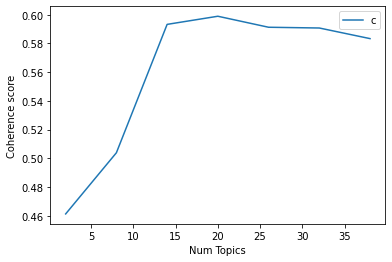

In [23]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### 16 - Escores de coerência



In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4612
Num Topics = 8  has Coherence Value of 0.5038
Num Topics = 14  has Coherence Value of 0.5933
Num Topics = 20  has Coherence Value of 0.5989
Num Topics = 26  has Coherence Value of 0.5913
Num Topics = 32  has Coherence Value of 0.5907
Num Topics = 38  has Coherence Value of 0.5833


#### 17 - Imprimir os tópicos do modelo com 20 tópicos


In [26]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.036*"key" + 0.014*"system" + 0.014*"bit" + 0.013*"encryption" + '
  '0.012*"technology" + 0.011*"chip" + 0.010*"security" + 0.010*"government" + '
  '0.010*"public" + 0.008*"message"'),
 (1,
  '0.013*"christian" + 0.010*"people" + 0.010*"religion" + 0.010*"word" + '
  '0.009*"man" + 0.008*"church" + 0.008*"faith" + 0.007*"life" + '
  '0.007*"belief" + 0.007*"love"'),
 (2,
  '0.023*"space" + 0.010*"system" + 0.008*"science" + 0.008*"launch" + '
  '0.008*"earth" + 0.008*"datum" + 0.008*"year" + 0.007*"research" + '
  '0.006*"cost" + 0.006*"project"'),
 (3,
  '0.951*"ax" + 0.002*"qax" + 0.001*"mwt" + 0.001*"fq" + 0.001*"biz" + '
  '0.000*"pmfq" + 0.000*"nrizwt" + 0.000*"zdk" + 0.000*"wwiz_bhj" + '
  '0.000*"pmf"'),
 (4,
  '0.022*"information" + 0.021*"mail" + 0.020*"send" + 0.019*"post" + '
  '0.019*"list" + 0.014*"address" + 0.013*"group" + 0.013*"include" + '
  '0.012*"internet" + 0.011*"email"'),
 (5,
  '0.013*"people" + 0.012*"armenian" + 0.010*"war" + 0.008*"israeli" + '
  

#### 18 - Tópico dominante

In [33]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.1717,"car, buy, price, sell, sale, good, line, drive...",From: (wheres my thing) Subject: WHAT car is t...
1,1,16.0,0.1601,"drive, card, problem, system, bit, driver, win...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,16.0,0.1442,"drive, card, problem, system, bit, driver, win...",From: (Thomas E Willis) Subject: PB questions....
3,3,13.0,0.0888,"write, article, line, organization, read, post...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,16.0,0.1051,"drive, card, problem, system, bit, driver, win...",From: (Jonathan McDowell) Subject: Re: Shuttle...


#### 19 - Os documentos mais representativos de cada tópico

In [34]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8983,"key, system, bit, encryption, technology, chip...",From: (Jim Gillogly) Subject: Clipper Chip and...
1,1.0,0.7104,"christian, people, religion, word, man, church...",From: (Robert Weiss) Subject: [lds] Ricks repl...
2,2.0,0.8076,"space, system, science, launch, earth, datum, ...",From: (Jon Leech) Subject: Space FAQ 11/15 - U...
3,3.0,0.8790,"ax, qax, mwt, fq, biz, pmfq, nrizwt, zdk, wwiz...",Subject: roman.bmp 12/14 From: (Cliff) Reply-T...
4,4.0,0.6218,"information, mail, send, post, list, address, ...",From: (Robert Lipman) Subject: CALL FOR PRESEN...


#### 20 - Distribuição de tópicos através de documentos

In [35]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,8.0,"car, buy, price, sell, sale, good, line, drive...",508.0,0.0449
1.0,16.0,"drive, card, problem, system, bit, driver, win...",802.0,0.0709
2.0,16.0,"drive, card, problem, system, bit, driver, win...",535.0,0.0473
3.0,13.0,"write, article, line, organization, read, post...",4.0,0.0004
4.0,16.0,"drive, card, problem, system, bit, driver, win...",410.0,0.0362
